# Writing and executing query recipes

A query recipe is written by an application expert and specifies their instructions for the inference of new knowledge about the real world. In this recipe they reference semantic concepts, as formalized in the ontology, directly by their name. That means that query recipes fall entirely into the semantic domain, and don’t contain any image domain terminology.

Since query recipes reference stable concepts that represent entities and events in the real world, they are largely independent from the data in the EO data cube, the rules in the mapping, and the location in space-time. Hence, the same query recipe can be used on different data sources, with different mappings, and at different locations in space-time. Only at the moment that a query recipe is executed, the application expert needs to provide the context in which the execution should happen.

This notebook shows how semantique allows an application expert to construct a query recipe, and how to execute it within a specific context.

## Content

- [Writing the recipe](#Writing-the-recipe)
- [Setting the context](#Setting-the-context)
- [Executing the recipe](#Executing-the-recipe)

## Prepare

Import packages:

In [1]:
import semantique as sq

In [2]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import json

## Writing the recipe

A query recipe in semantique is represented by an instance of the [QueryRecipe](https://zgis.github.io/semantique/_generated/semantique.QueryRecipe.html) class. Such an object has the same structure as a Python dictionary, with each element containing the instructions for a single result, indexed by the name of that result. The starting point for the application expert using semantique is to initialize an empty instance of a recipe.

In [3]:
recipe = sq.QueryRecipe()

The instructions for each desired result can then be added one by one as elements to this object. The instructions can be intuitively formulated by chaining together basic building blocks in a *with-do* structure.

The *with* part of the chain is the textual reference to a semantic concept. Such a reference can be formulated by providing the index of the concept to the [concept()](https://zgis.github.io/semantique/_generated/semantique.concept.html) function. The index consists of the category (or optionally multiple levels of categories) to which the concept belongs, and the name of the concept itself. The structure and depth of the categorization depends on the ontology. For convenience, commonly used categories are implemented as separate functions, such that only the name of the concept has to be provided. These are the [entity()](https://zgis.github.io/semantique/_generated/semantique.entity.html) and [event()](https://zgis.github.io/semantique/_generated/semantique.event.html) functions. For more details on the reference specification, and an overview of other types of references that may be used, see the [References notebook](references.ipynb).

In [4]:
water = sq.entity("water")
print(json.dumps(water, indent = 2))

{
  "type": "concept",
  "reference": [
    "entity",
    "water"
  ]
}


Note that this reference is nothing more than a simple textual object. Only when the recipe is executed, the semantic concept reference will be translated into a semantic array. A semantic array is a multi-dimensional array that for each observation within a spatio-temporal extent quantifies a direct relation with a semantic concept. Such a relation may be binary, stating if the concept was observed (“true”) or not (“false”). However, relations may also be numeric (e.g. a probability that the concept was observed) or ordinal (e.g. “likely” or “very likely” that the concept was observed).

In the *do* part of the processing chain, the application expert can specify one or more analytical processes that should be applied to this semantic array, in order to obtain the desired result. Each of these processes is a well-defined array operation that performs a single task. It is labeled by an action word that should intuitively describe the operation it performs. Therefore we also call these type of building blocks *verbs*. Semantique offers many different verbs, which are all described in the [Verbs notebook](verbs.ipynb). The verbs can be called as methods of the reference.

In [5]:
count = sq.entity("water").reduce("count", "time")
print(json.dumps(count, indent = 2))

{
  "type": "processing_chain",
  "with": {
    "type": "concept",
    "reference": [
      "entity",
      "water"
    ]
  },
  "do": [
    {
      "type": "verb",
      "name": "reduce",
      "params": {
        "reducer": "count",
        "dimension": "time"
      }
    }
  ]
}


Note that the resulting object is still entirely textual, not containing any data nor Python code. The recipe can be made increasingly complex by adding more verbs to the chain, by nesting multiple processing chains into each other, or by modelling split-apply-combine structures. See the [Gallery notebook](gallery.ipynb) for several practical examples of query recipes.

Now, lets fill our empty recipe with some simple result instructions. We can do so by adding each result as an element to the dictionary.

In [6]:
recipe["blue_map"] = sq.entity("water").reduce("count", "time")
recipe["green_map"] = sq.entity("vegetation").reduce("count", "time")
recipe["blue_curve"] = sq.entity("water").reduce("count", "space")
recipe["green_curve"] = sq.entity("vegetation").reduce("count", "space")
recipe["blue_stat"] = sq.entity("water").reduce("count")
recipe["green_stat"] = sq.entity("vegetation").reduce("count")

Since the recipe is entirely textual and does not contain any data nor code, it is easily shareable as a JSON file, such that a single recipe can be re-used several times by multiple people.

In [7]:
with open("files/recipe.json", "w") as file:
    json.dump(recipe, file, indent = 2)

The recipe we just constructred looks like [this](https://github.com/ZGIS/semantique/blob/main/demo/files/recipe.json).

## Setting the context

When executing a query recipe, the context in which it should be executed needs to be provided. This includes the mapping that maps the referenced semantic concepts to data values, the EO data cube containing these data, and the bounds of a spatio-temporal extent. Note that the context should always fit the recipe. A recipe referencing the semantic concept *water* can never be executed against a mapping that does not define water, nor against a mapping that defines water in terms of data values that do not exist in the provided EO data cube.

### Representing an EO data cube

In semantique, an EO data cube is always represented by its layout. The layout is a JSON-structured file containing a metadata object for each data layer in the cube. The software expert should distribute it alongside the EO data cube, such that the application expert can use it to initialize a Python object that represents the cube. Such an object contains a retriever method allowing the query processor to retrieve data values from the cube.

When initializing the data cube object, the application expert needs to know what the configuration of the cube is. A configuration is a specific way in which the cube is organized and how to interact with it. Each specific EO data cube configuration should have its own dedicated class in semantique. For more information on that, see the notebook on [Representing an EO data cube](datacube.ipynb). Hence, to represent an EO data cube, the application expert should create an instance of the class that is dedicated to the specific configuration of that cube.

Currently, there are two EO data cube configurations natively supported by semantique. The first one is the [Opendatacube](https://zgis.github.io/semantique/_generated/semantique.datacube.Opendatacube.html) class, dedicated to data cubes using the [Open Data Cube software](https://www.opendatacube.org/). The second one is the [GeotiffArchive](https://zgis.github.io/semantique/_generated/semantique.datacube.GeotiffArchive.html) class, dedicated to data cubes consisting of multiple GeoTIFF files compressed together in a ZIP archive. The latter format is much more primivite, and only intended for demonstration purposes or very basic use-cases. We use it in our documentation. For other EO data cube configurations, the software expert should write a dedicated class and provide it to the application expert.

The EO data cube representation in semantique never contains the data themselves! Instead, a parameter should be provided that specifies the location of the data. How this paramater looks like, depends on the configuration of the cube. In the case of the Opendatacube class, it is an ODC-specific connection object, while in the case of the GeotiffArchive class, it is the file path to the ZIP-file containing the GeoTIFF files.

In [8]:
with open("files/layout.json", "r") as file:
    dc = sq.datacube.GeotiffArchive(json.load(file), src = "files/layers.zip")

### Importing a mapping

In semantique, a mapping is expected to be a JSON-structured file containing the rules that map each semantic concept to data values in an EO data cube. The EO expert should distribute the mapping, such that the application expert can load it into its Python session. With the loaded mapping, they can initialize a Python object that represents it. Such an object contains a translator method allowing the query processor to translate textual concept references.

When initializing the mapping object, the application expert needs to know what the configuration of the mapping is. A configuration is a specific way in which the rules are formulated and how they should be executed. Each specific mapping configuration should have its own dedicated class in semantique. For more information on that, see the notebook on [Constructing a mapping](mapping.ipynb). Hence, after loading a mapping, the application expert should create an instance of the class that is dedicated to the specific configuration of that mapping.

Semantique provides its own native mapping configuration through the [Semantique](https://zgis.github.io/semantique/_generated/semantique.mapping.Semantique.html) class. For other mapping configurations, the EO expert should write a dedicated class and provide it to the application expert.

In [9]:
with open("files/mapping.json", "r") as file:
    mapping = sq.mapping.Semantique(json.load(file))

### Setting the spatio-temporal extent

To model a spatial extent, semantique contains the [SpatialExtent](https://zgis.github.io/semantique/_generated/semantique.extent.SpatialExtent.html) class. An instance of this class can be initialized by providing it any object that can be read by the [GeoDataFrame](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.html) initializer of the [geopandas](https://geopandas.org/en/stable/) package. Any additional keyword arguments will be forwarded to this initializer. In practice, this means any GDAL-supported file format can be loaded into Python with [geopandas.read_file()](https://geopandas.org/en/stable/docs/reference/api/geopandas.read_file.html), and then used to initialize a spatial extent. A spatial extent can also consist multipe spatial features. However, these features should not overlap, since a spatial pixel in the rasterized extent can only belong to one feature. If multiple features do overlap, a pixel will be assigned to the one that comes first in the feature collection.

In most of our documentation we use a small, rectangular area around Zell am See in Salzbuger Land, Austria.

In [10]:
geodf = gpd.read_file("files/footprint.geojson")
geodf.explore()

In [11]:
space = sq.SpatialExtent(geodf)

To model a temporal extent, semantique contains the [TemporalExtent](https://zgis.github.io/semantique/_generated/semantique.extent.TemporalExtent.html) class. An instance of this class can be initialized by providing it lower and upper bound of a time interval. The given interval is treated as being closed at both sides, meaning both of its bounds are included in the interval. The bounds may be provided as character formatted dates, e.g. "2020-12-31" or "2020/12/31", but also complete ISO8601 timestamps, e.g. "2020-12-31T14:37:22". As long as the [Timestamp](https://pandas.pydata.org/docs/reference/api/pandas.Timestamp.html) initializer of the [pandas](https://pandas.pydata.org/) package can understand it, it is supported by semantique. Any additional keyword arguments will be forwarded to this initializer.

In [12]:
time = sq.TemporalExtent("2019-01-01", "2020-12-31")

### Collecting the full context

Now we can collect the full context in a single dictionary, which we can later provide when [executing the recipe](#Executing-the-recipe). In addition to the different components described above, we may add additional configuration parameters that tune the behaviour of the query processor. These include the desired coordinate reference system (CRS) in which spatial coordinates should be represented, as well as the time zone in which temporal coordinates should be represented. You should also provide the desired spatial resolution of the output, as a list containing respectively the y and x resolution in CRS units (i.e. usually meters for projected CRS and degrees for geographic CRS) and including direction. Note that for most CRS, that means that the first value (i.e. the y-value) of the resolution will always be negative. For other possible configuration parameters, see the notebook on [Internal query processing](processor.ipynb).

In [13]:
context = {
    "datacube": dc, 
    "mapping": mapping,
    "space": space,
    "time": time,
    "crs": 3035, 
    "tz": "UTC", 
    "spatial_resolution": [-10, 10]
}

## Executing the recipe

Now we are ready to execute our query recipe. Hooray! This step is quite simple. You call the [execute()](https://zgis.github.io/semantique/_generated/semantique.QueryRecipe.execute.html) method of our recipe object, and provide it with the required context. Then, just be a bit patient...  Internally, the query processor will solve all references, evaluate them into arrays, and apply the verbs to them. In the notebook on [Internal query processing](processor.ipynb) the internal implementation of query processing is described in some more detail.

In [14]:
response = recipe.execute(**context)

The response of the query processor is a dictionary which one element per result. Each of these elements is an array modelled as an instance of the [DataArray](http://xarray.pydata.org/en/stable/user-guide/data-structures.html#dataarray) class from the [xarray](https://docs.xarray.dev/en/stable/) package. This package serves as the backbone for most of the analysis tasks the query processor performs.

In [15]:
for key in response:
    print(f"{key}: {type(response[key])}")

blue_map: <class 'xarray.core.dataarray.DataArray'>
green_map: <class 'xarray.core.dataarray.DataArray'>
blue_curve: <class 'xarray.core.dataarray.DataArray'>
green_curve: <class 'xarray.core.dataarray.DataArray'>
blue_stat: <class 'xarray.core.dataarray.DataArray'>
green_stat: <class 'xarray.core.dataarray.DataArray'>


The dimensions the arrays depend on the actions that were called in the result instruction. Some results might only have spatial dimensions (i.e. a map):

In [16]:
response["blue_map"]

<xarray.DataArray 'blue_map' (y: 563, x: 576)>
array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * x              (x) float64 4.53e+06 4.53e+06 ... 4.536e+06 4.536e+06
  * y              (y) float64 2.697e+06 2.697e+06 ... 2.691e+06 2.691e+06
    spatial_ref    int64 0
    temporal_ref   int64 0
    spatial_feats  (y, x) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    value_type:  discrete

Other results might only have the temporal dimension (i.e. a time series):

In [17]:
response["blue_curve"]

<xarray.DataArray 'blue_curve' (time: 3)>
array([    0., 44804., 78607.])
Coordinates:
  * time          (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-1...
    spatial_ref   int64 0
    temporal_ref  int64 0
Attributes:
    value_type:  discrete

And other results might even be dimensionless (i.e. a single aggregated statistic):

In [18]:
response["blue_stat"]

<xarray.DataArray 'blue_stat' ()>
array(123411.)
Coordinates:
    spatial_ref   int64 0
    temporal_ref  int64 0
Attributes:
    value_type:  discrete

There may also be results that contain both the spatial and temporal dimension, as well as results that contain an additonal, thematic dimension.

Since the result objects are [DataArray](http://xarray.pydata.org/en/stable/user-guide/data-structures.html#dataarray) objects, we can use xarray for any further processing, and also to visualize the results. Again, see the [xarray documentation](http://xarray.pydata.org/en/stable/index.html) for more details on what that package has to offer (which is a lot!). For now, we will just plot some of our obtained results to give an impression. In the [Gallery notebook](gallery.ipynb) you can find much more of such examples.

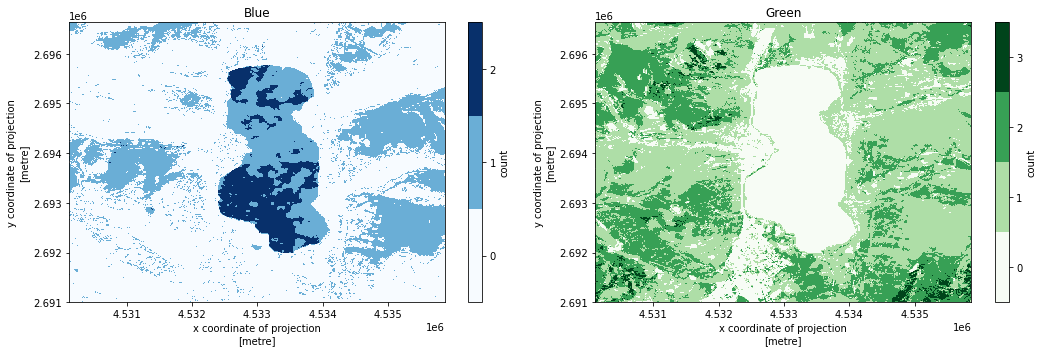

In [19]:
def make_plot(axis, array, colors, title):
    values = list(range(int(np.nanmin(array)), int(np.nanmax(array)) + 1))
    levels = [x - 0.5 for x in values + [max(values) + 1]]
    legend = {"ticks": values, "label": "count"}
    array.plot(ax = axis, levels = levels, cmap = colors, cbar_kwargs = legend)
    axis.set_title(title)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

make_plot(ax1, response["blue_map"], plt.cm.Blues, "Blue")
make_plot(ax2, response["green_map"], plt.cm.Greens, "Green")

plt.tight_layout()
plt.draw()